In [1]:
install.packages("CVThresh")
install.packages("PLRModels")
install.packages("KernSmooth")
library("CVThresh")
library("PLRModels")
library("KernSmooth")
library("ggplot2")
library("splines")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘wavethresh’, ‘EbayesThresh’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: wavethresh

Loading required package: MASS

WaveThresh: R wavelet software, release 4.7.2, installed


Copyright Guy Nason and others 1993-2022


Note: nlevels has been renamed to nlevelsWT


Loading required package: EbayesThresh

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



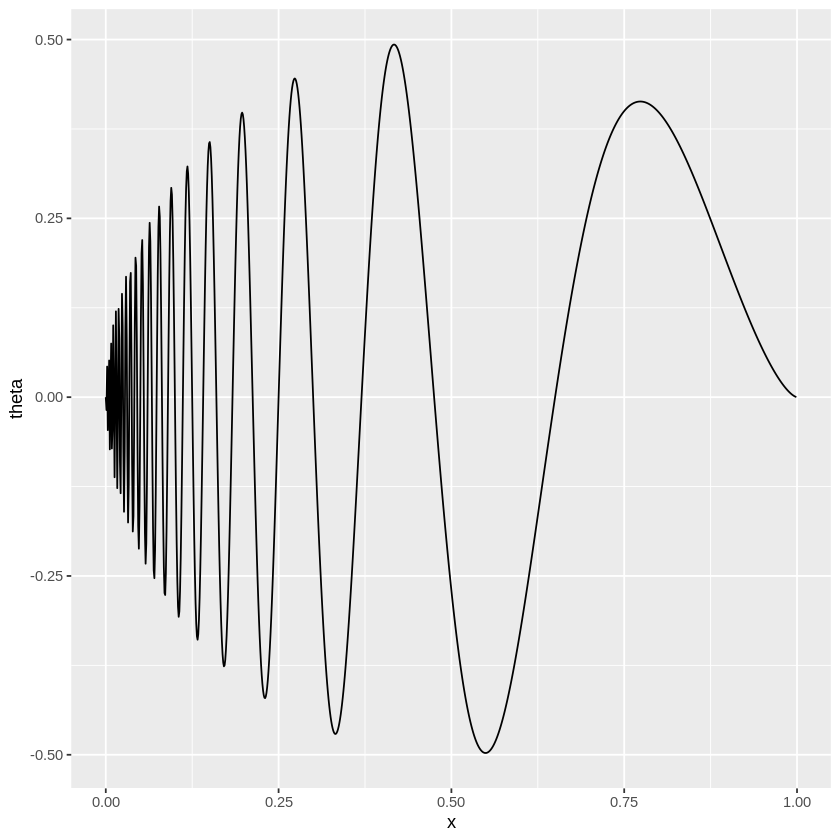

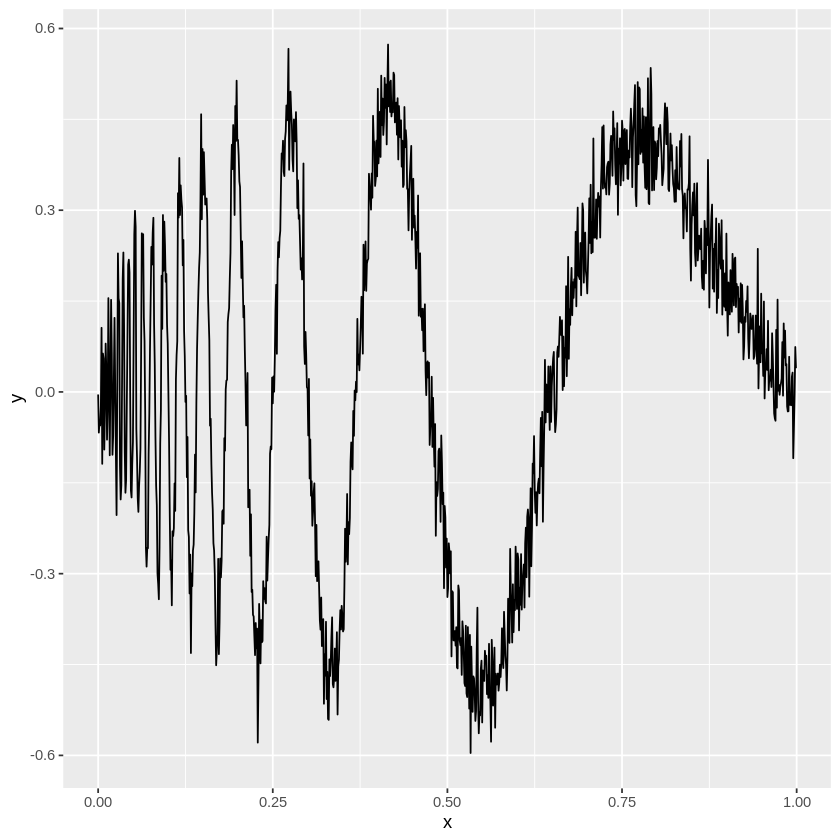

In [2]:
# data generation
set.seed("2023")

n = 1024  # sample size
f = dopp(n)
x = f$x   # values of x
theta = f$meanf  # true values of f(x)
y = rnorm(n, mean = theta, sd = 0.05)   # noisy values y of f(x)
df = data.frame(x,y)

# visualize the data
ggplot(df) + geom_line(aes(x,theta))
ggplot(df) + geom_line(aes(x,y))

[1] 0.001235498


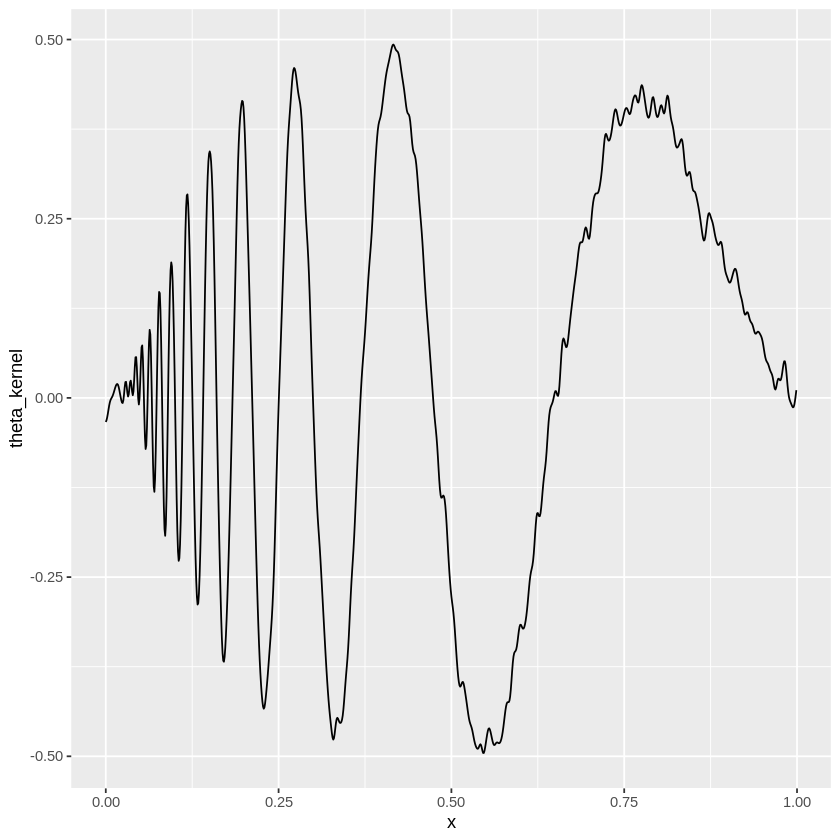

In [3]:
### YOUR CODE (~2 lines): implement the Nadaraya--Watson estimator
# you may use ksmooth() function with a Gaussian kernel
# select a data-driven bandwidth based on the following function:
# dpill: https://search.r-project.org/CRAN/refmans/KernSmooth/html/dpill.html

theta_kernel = ksmooth(df$x, df$y, kernel = "normal", bandwidth = dpill(df$x, df$y))$y

# visualization and MSE
ggplot(df) + geom_line(aes(x, theta_kernel))
print(mean((theta_kernel - theta)^2))

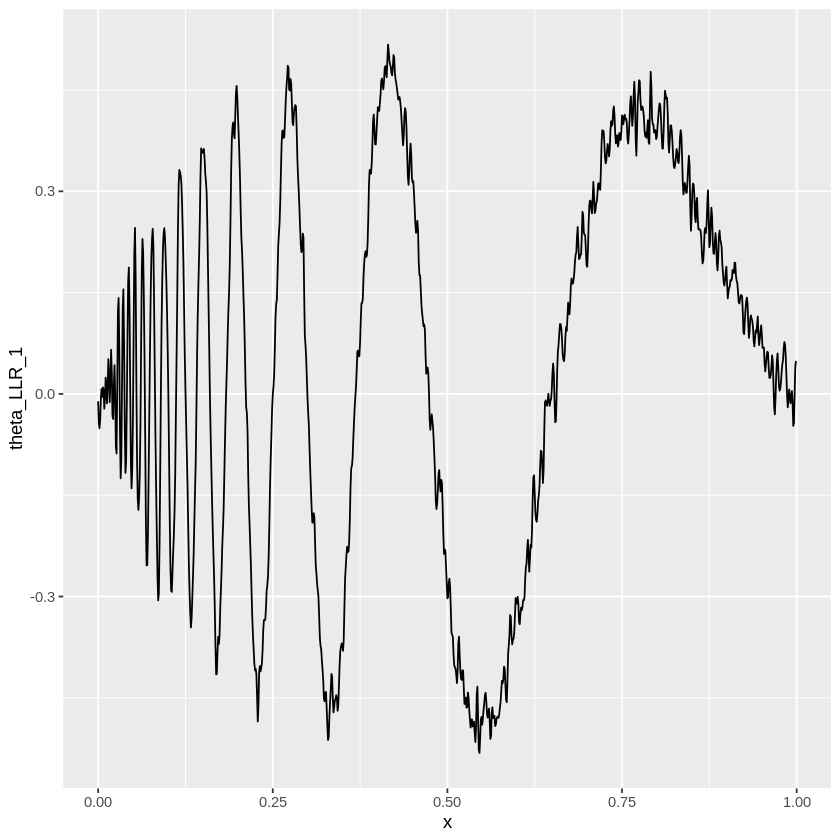

[1] 0.0008400274
[1] 0.001088059


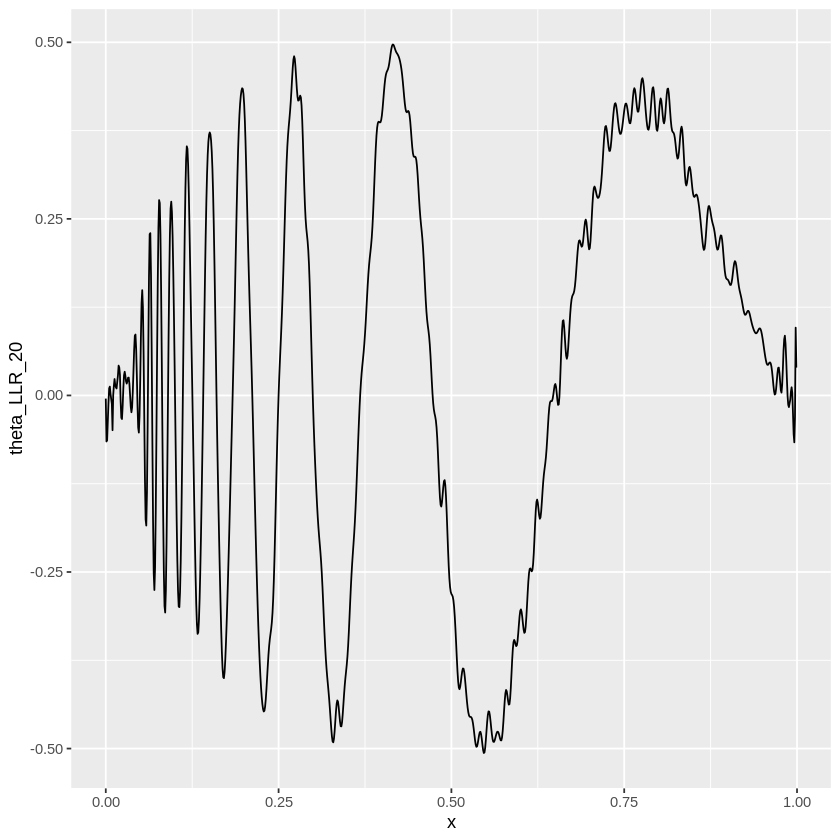

In [4]:
### YOUR CODE (~2 lines): implement the local polynomial regressions
# compute the fits for two sets of hyperparameters
# hyperparameter 1: degree = 1, bandwidth = 0.001
# hyperparameter 2: degree = 20, bandwidth = 0.01
# Gaussian kernel is used in both scenarios
# you may find locpoly() function useful
# you may also play with different bandwidths yourself to see what happens

theta_LLR_1 = locpoly(df$x, df$y, degree = 1, bandwidth = 0.001, kernel = "normal", gridsize = 1024)$y
theta_LLR_20 = locpoly(df$x, df$y, degree = 20, bandwidth = 0.01, kernel = "normal", gridsize = 1024)$y

# visualization and MSE
ggplot(df) + geom_line(aes(x, theta_LLR_1))
ggplot(df) + geom_line(aes(x, theta_LLR_20))
print(mean((theta_LLR_1 - theta)^2))
print(mean((theta_LLR_20 - theta)^2))

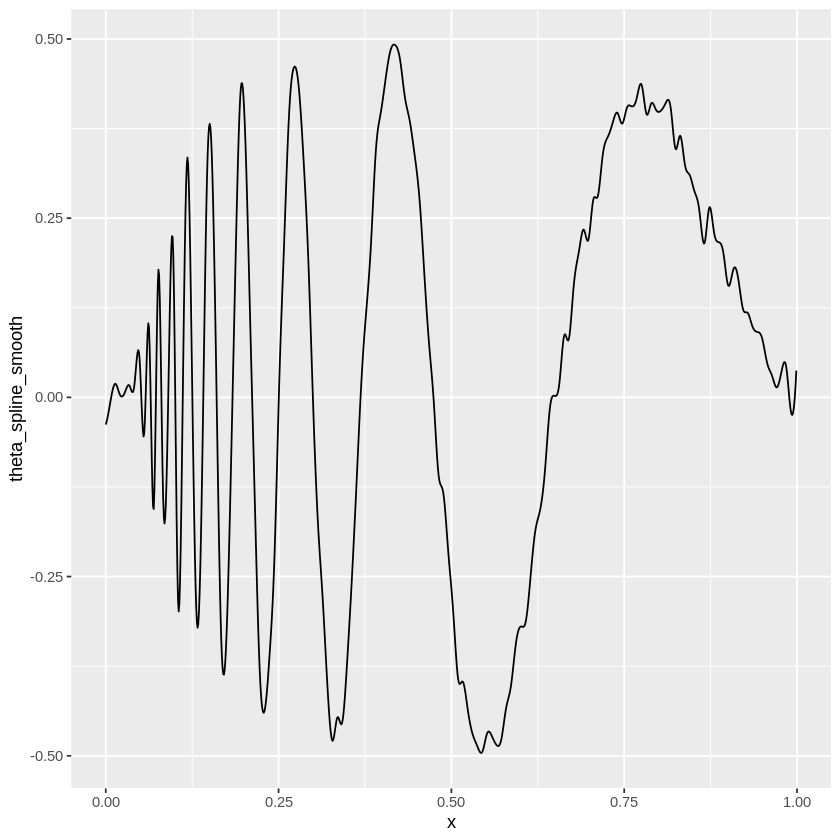

[1] 0.00161096
[1] 0.001278096


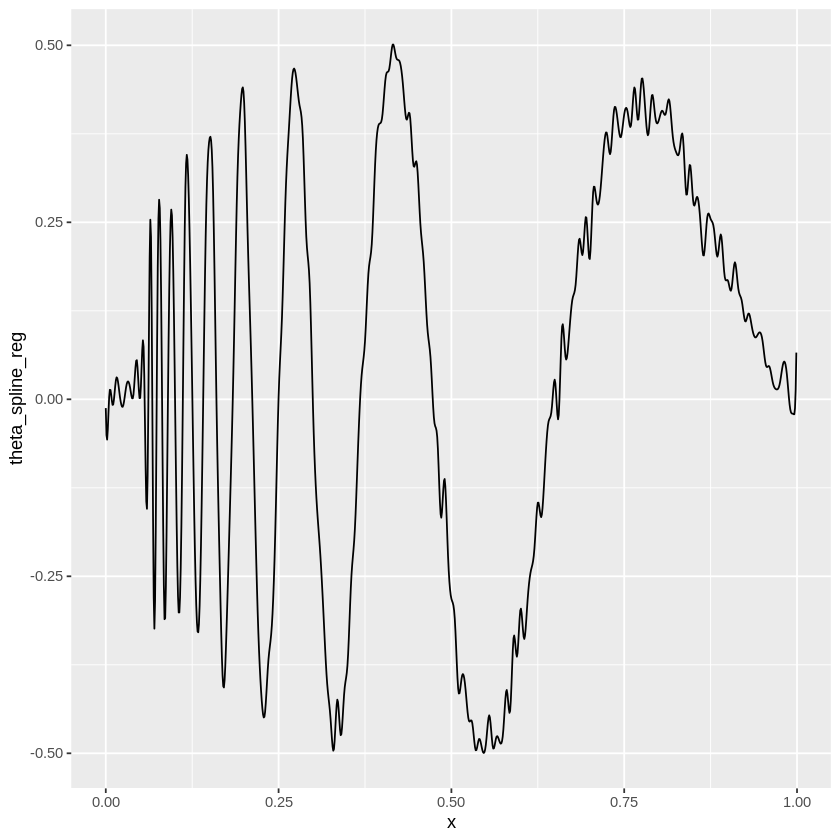

In [5]:
### YOUR CODE: implement the cubic smoothing and regression spline estimates
# for smoothing spline (~1 line): use smooth.spline() and cross validation to
# set the parameters
# for regression spline (~3 lines): use B-spline bs() of degree 3, with knots
# {0, 0.005, ..., 0.995}. Then fit a linear model.

theta_spline_smooth = predict(smooth.spline(df$x, df$y, cv = TRUE), df$x)$y

knots = seq(0, 0.995, by = 0.005)
spline_reg = lm(y ~ bs(x, knots = knots, degree = 3), data = df)
theta_spline_reg = predict(spline_reg, newdata = data.frame(x = df$x))

# visualization and MSE
ggplot(df) + geom_line(aes(x, theta_spline_smooth))
ggplot(df) + geom_line(aes(x, theta_spline_reg))
print(mean((theta_spline_smooth - theta)^2))
print(mean((theta_spline_reg - theta)^2))

[1] 0.001140976


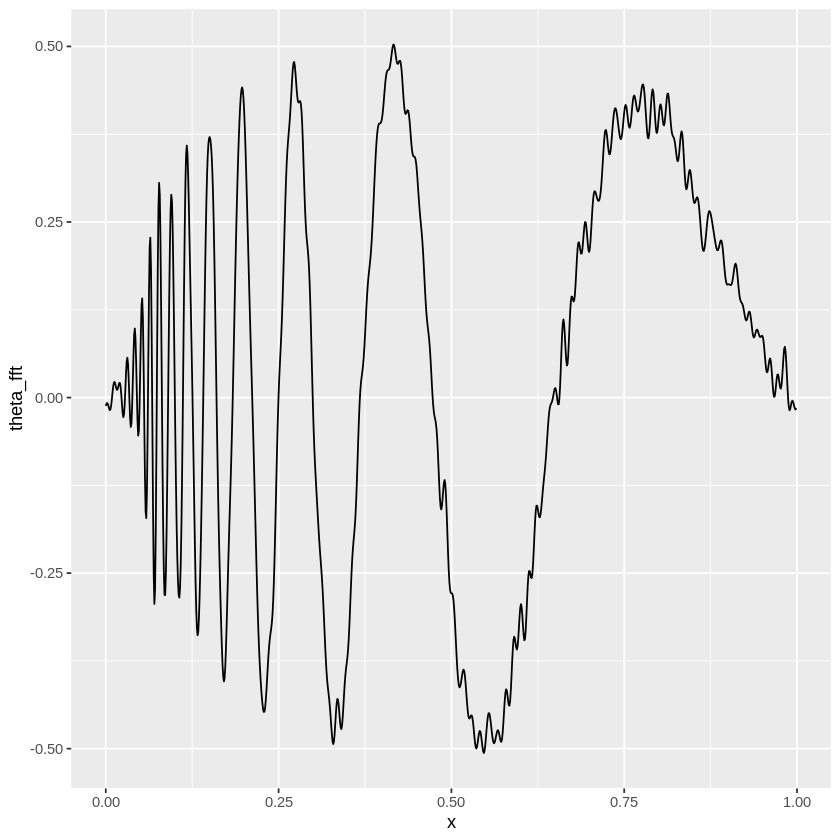

In [6]:
### YOUR CODE (~3 lines): implement the Fourier projection estimator
# use fft() to compute the (inverse) Fourier transform, and
# only keep the first and last 100 coefficients
# Note 1: you may need to normalize your final result by n
# Note 2: for the final plot, you may need to take the real part of complex values

fft_result = fft(df$y)
fft_result[101:(n-100)] = 0
theta_fft = Re(fft(fft_result, inverse = TRUE))/n

# visualization and MSE
ggplot(df) + geom_line(aes(x, theta_fft))
print(mean((theta_fft - theta)^2))

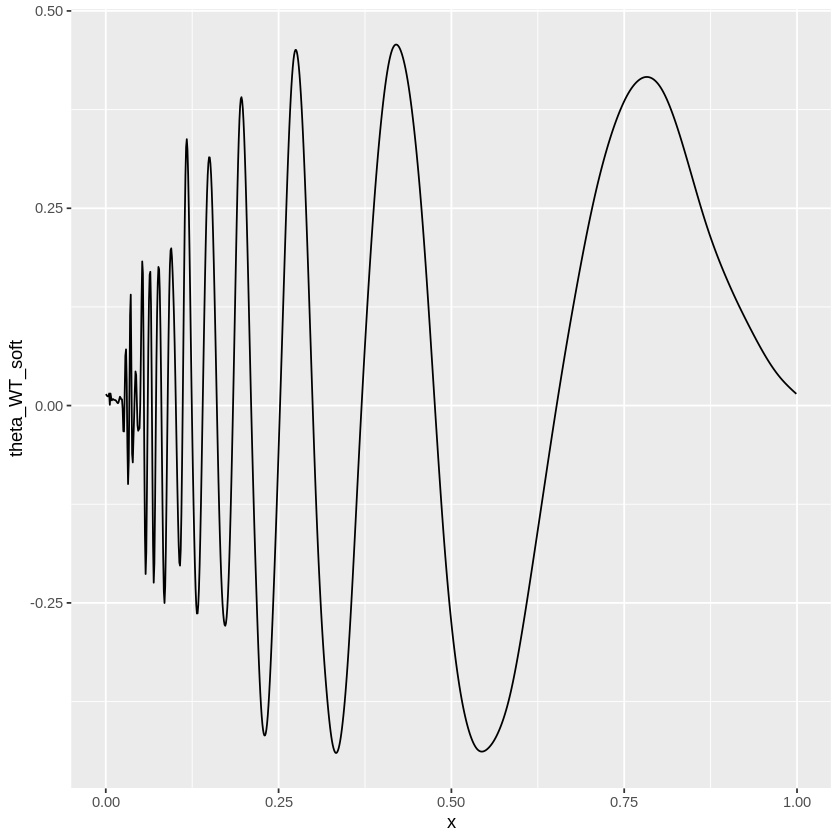

[1] 0.001524017
[1] 0.0005815723


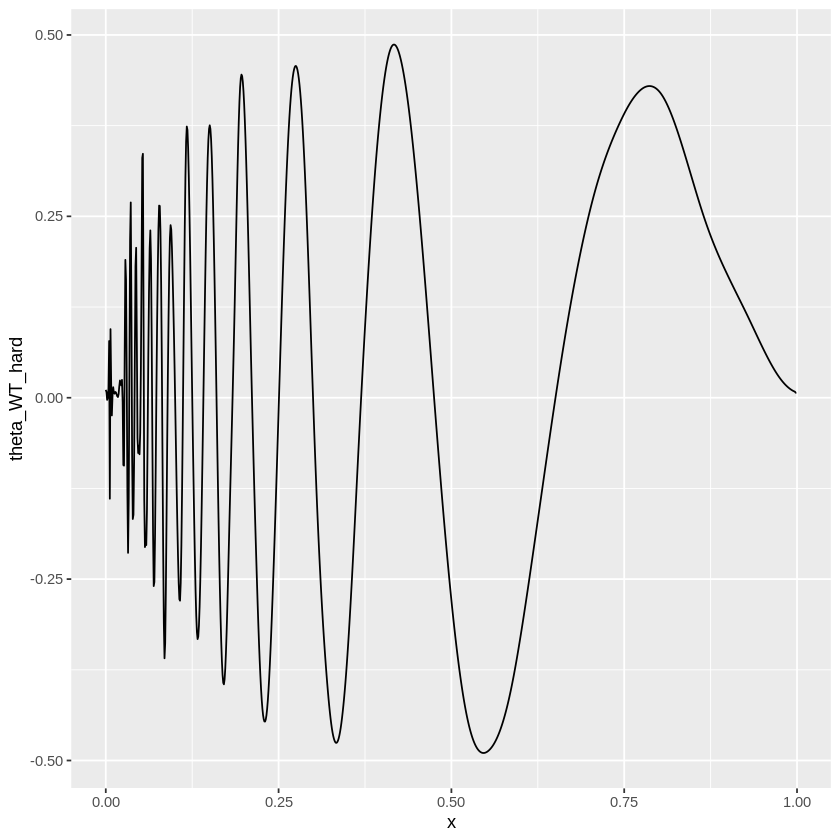

In [7]:
### YOUR CODE (~6 lines): implement the wavelet thresholding estimators
# You should implement both soft and hard thresholding estimators
# the "threshold" function and the examples therein might be useful:
# https://search.r-project.org/CRAN/refmans/wavethresh/html/threshold.wd.html
# you may set policy = "universal" to choose thresholds

# soft_threshold = threshold(wd(df$y), type = "soft", policy = "universal")
# hard_threshold = threshold(wd(df$y), type = "hard", policy = "universal")
# theta_WT_soft = wr(soft_threshold)
# theta_WT_hard = wr(hard_threshold)

y_wd = wd(y)
thresh = threshold(y_wd, policy="universal", levels= nlevelsWT(y_wd)-1, return.threshold=TRUE)
y_wd_soft = threshold(y_wd, type="soft", policy="manual", value=thresh, levels=0:(nlevelsWT(y_wd)-1))
y_wd_hard = threshold(y_wd, type="hard", policy="manual", value=thresh, levels=0:(nlevelsWT(y_wd)-1))
theta_WT_soft = wr(y_wd_soft)
theta_WT_hard = wr(y_wd_hard)

# visualization and MSE
ggplot(df) + geom_line(aes(x,theta_WT_soft))
ggplot(df) + geom_line(aes(x,theta_WT_hard))
print(mean((theta_WT_soft - theta)^2))
print(mean((theta_WT_hard - theta)^2))

In [8]:
### Code Link
# https://colab.research.google.com/drive/1330sshZS81UiB6tgL3uDSPvQ_b7weeNG?usp=sharing